## Loading Libraries

In [23]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy import interp
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

## Setting Options

In [2]:
pd.options.display.max_columns = 100
plt.style.use('fivethirtyeight')

%matplotlib inline

## Preparing Data

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train.info() #over 200 missing values found for column gender.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.3+ KB


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10000.0,37.991800,13.038203,16.000000,27.000000,38.000000,49.000000,60.000000
cost_of_ad,10000.0,0.004666,0.000838,0.003171,0.003995,0.004625,0.005164,0.007082
in_initial_launch_location,10000.0,0.497500,0.500019,0.000000,0.000000,0.000000,1.000000,1.000000
income,10000.0,58004.335800,17330.778355,16241.000000,45533.500000,58053.500000,70235.250000,99956.000000
n_drivers,10000.0,1.497000,0.500016,1.000000,1.000000,1.000000,2.000000,2.000000
n_vehicles,10000.0,2.002200,0.817840,1.000000,1.000000,2.000000,3.000000,3.000000
prior_ins_tenure,10000.0,5.406800,5.046014,0.000000,1.000000,4.000000,8.000000,22.000000
outcome,10000.0,0.098200,0.297600,0.000000,0.000000,0.000000,0.000000,1.000000


In [6]:
#check for class imbalance
df_train['outcome'].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

As shown, we have a very imbalanced class. Since we have only 10,000 observations to train the model, let's use oversampling to address this problem.

In [7]:
df_positive = df_train[df_train['outcome'] ==1]
df_negative = df_train[df_train['outcome'] ==0]

### Functions for Data Visualization

In [8]:
def stack_plot(df_all,df_positive,feature,colour1, colour2):
    print 'all cases count'
    print df_all[feature].value_counts().sort_index()
    print 'positive cases count'
    print df_positive[feature].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    barlabels = list(df_all[feature].value_counts().sort_index().index)
    plt.bar(range(len(barlabels)),df_all[feature].value_counts().sort_index(), color = colour1)
    plt.bar(range(len(barlabels)),df_positive[feature].value_counts().sort_index(), color = colour2)
    plt.xticks(range(len(barlabels)), barlabels, rotation=45);
    plt.xlabel(feature)
    plt.ylabel('count')
   

all cases count
0     1648
1     1159
2      995
3      801
4      734
5      642
6      627
7      510
8      411
9      411
10     328
11     299
12     279
13     240
14     214
15     155
16     153
17     133
18     101
19      75
20      51
21      27
22       7
Name: prior_ins_tenure, dtype: int64
positive cases count
0     178
1     151
2      98
3      81
4      64
5      71
6      51
7      32
8      32
9      46
10     20
11     29
12     22
13     21
14     24
15     11
16     16
17     12
18      8
19      7
20      4
21      3
22      1
Name: prior_ins_tenure, dtype: int64


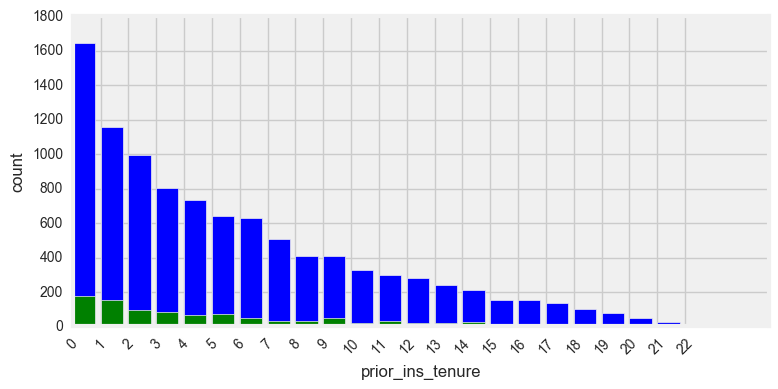

In [9]:
stack_plot(df_train,df_positive,'prior_ins_tenure','blue', 'green')

all cases count
1    5030
2    4970
Name: n_drivers, dtype: int64
positive cases count
1    345
2    637
Name: n_drivers, dtype: int64


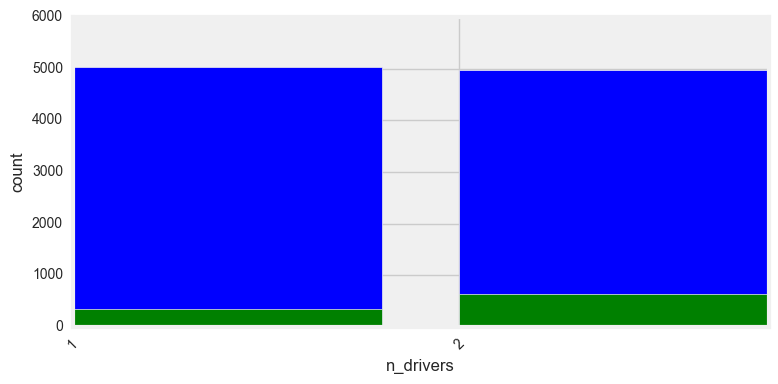

In [10]:
stack_plot(df_train,df_positive,'n_drivers','blue', 'green')

all cases count
1    3333
2    3312
3    3355
Name: n_vehicles, dtype: int64
positive cases count
1    608
2    234
3    140
Name: n_vehicles, dtype: int64


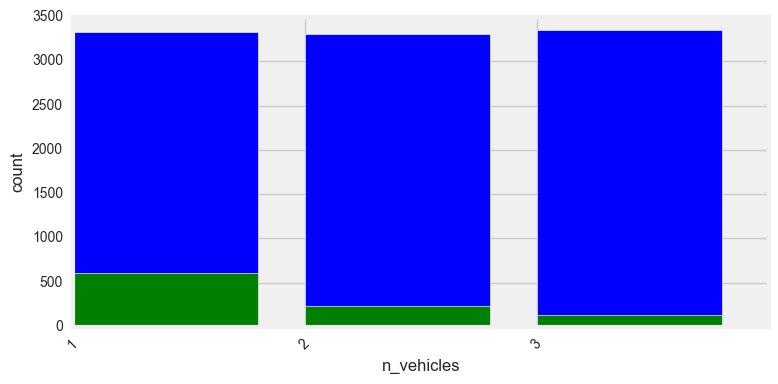

In [11]:
stack_plot(df_train,df_positive,'n_vehicles','blue', 'green')

all cases count
0    5025
1    4975
Name: in_initial_launch_location, dtype: int64
positive cases count
0    320
1    662
Name: in_initial_launch_location, dtype: int64


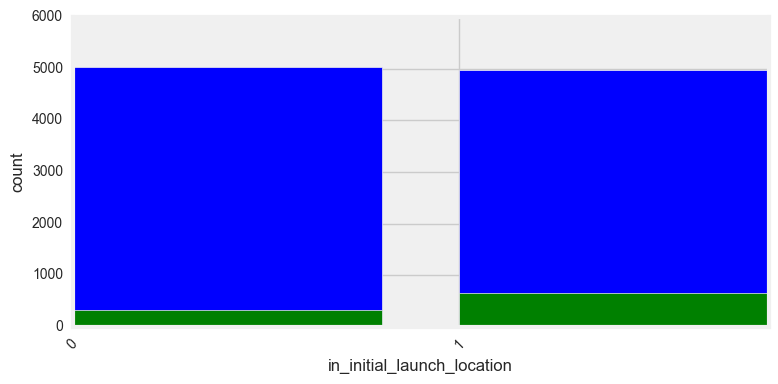

In [12]:
stack_plot(df_train,df_positive,'in_initial_launch_location','blue', 'green')

In [13]:
# since the missing values account for less than 3% of our data, I drop the entries with missing values.
df_train= df_train[df_train['gender'].notnull()]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9731 entries, 0 to 9998
Data columns (total 10 columns):
age                           9731 non-null int64
cost_of_ad                    9731 non-null float64
device_type                   9731 non-null object
gender                        9731 non-null object
in_initial_launch_location    9731 non-null int64
income                        9731 non-null int64
n_drivers                     9731 non-null int64
n_vehicles                    9731 non-null int64
prior_ins_tenure              9731 non-null int64
outcome                       9731 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 836.3+ KB


In [14]:
df_train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


### Feature Engineering Exploration

In [15]:
pd.crosstab(df_train['n_drivers'],df_train['n_vehicles'])

pd.crosstab(df_positive['n_drivers'],df_train['n_vehicles'])

n_vehicles,1.0,2.0,3.0
n_drivers,,,
1.0,214,80,47
2.0,390,153,89


We can see that when more drivers share fewer vehicles, there are relative more positive outcome cases. Thus, we should feature engineer a new column represent the ratio of driver and vehicles.

all cases count
0.5    1612
1.0    3240
1.5    1627
2.0    1638
3.0    1614
Name: vehicles_per_driver, dtype: int64
positive cases count
0.5    390
1.0    367
1.5     89
2.0     80
3.0     47
Name: vehicles_per_driver, dtype: int64


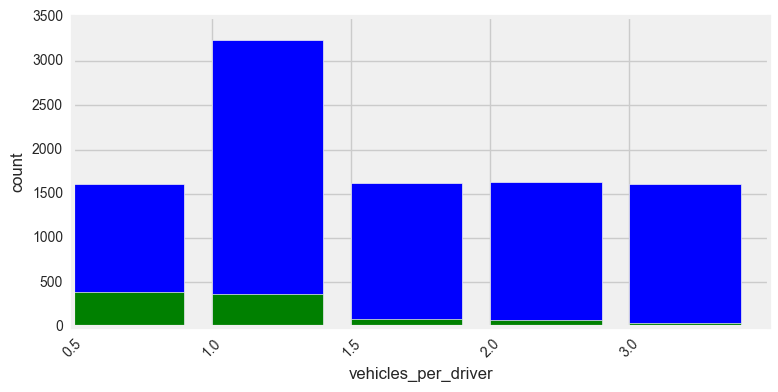

In [16]:
# adding a column 'vehicles_per_driver' to the existing dataframe.
df_train['vehicles_per_driver'] = df_train['n_vehicles'] / df_train['n_drivers'].astype('float')
df_positive['vehicles_per_driver'] = df_train['n_vehicles'] / df_train['n_drivers'].astype('float')

stack_plot(df_train,df_positive,'vehicles_per_driver','blue', 'green')

In [ ]:
#check for class imbalance
df_train['outcome'].value_counts()

As shown, we have an imbalanced class of ratio roughly 9:1


In [18]:
#Transform categorical columns. 'in_initial_launch_location' is already numerical form. So we only transform 
#categorical columns 'gender' and 'device_type'
cols_to_transform = [ 'gender','device_type']
df_train = pd.get_dummies( df_train,columns = cols_to_transform )
#since categorial column gender only takes on two values, we drop one.
df_train.drop('gender_M', axis=1, inplace=True)

df_train.head()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,vehicles_per_driver,gender_F,device_type_Android,device_type_desktop,device_type_iPhone,device_type_laptop,device_type_other
0,56,0.005737,0,62717,2,1,4,0,0.5,0.0,0.0,0.0,1.0,0.0,0.0
1,50,0.004733,0,64328,2,3,2,0,1.5,1.0,0.0,1.0,0.0,0.0,0.0
2,54,0.004129,0,83439,1,3,7,0,3.0,0.0,0.0,0.0,0.0,1.0,0.0
3,16,0.005117,0,30110,2,3,0,0,1.5,1.0,1.0,0.0,0.0,0.0,0.0
4,37,0.003635,0,76565,2,1,5,0,0.5,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
#set outcome label array
y= df_train.pop('outcome').values
#set feature matrix
X = df_train.values

## Resampling for Imbalanced Classes

Since there are only nine features in the dataset and the spread of value is not large, we apply random undersampling technique on majority class for its simplicity and to avoid the possibility of overfitting introduced by random oversampling and SMOTE.

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_sampled, y_sampled = rus.fit_sample(X, y)

In [24]:
#check if oversampling is successful
print len(y_sampled)
print Counter(y_sampled)

1946
Counter({0: 973, 1: 973})


## Testing Initial Model 

Reason for using ROC _AUC as the scoring metric:
1.ROC analysis allows us to select possibly optimal models withtou the need to specify the cost context.
2.ROC curves also give us the ability to assess the performance of the classifier over its entire operating range

The non-linear nature of the problem makes decision trees appealing. But, it makes sense to use an ensemble model (random forest, gradient boosting) to get the best performance.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.20, random_state=6, stratify=y)
fix_fold = StratifiedKFold(6, random_state=1).get_n_splits() 

In [26]:
#training GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05,random_state=6)

print 'The cross-validated AUC for GradientBoostingClassifier is {:.6f} .'.format(np.mean(cross_val_score(gbc, X_train, y_train, cv= fix_fold, scoring='roc_auc')))

The cross-validated AUC for GradientBoostingClassifier is 0.822197 .


In [27]:
#training RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='auto')

print 'The cross-validated AUC for RandomForestClassifier is {:.6f} .'.format(np.mean(cross_val_score(rfc, X_train, y_train, cv= fix_fold, scoring='roc_auc')))

The cross-validated AUC for RandomForestClassifier is 0.839494 .


Random forest perform slightly better than the Gradient Boosting model. The performance is not too bad, but it might be better.
Let try using grid search to find the best tuning parameters of each model.

### Refine gradient boosting and random forest model via grid search

In [32]:
gbc_grid = {
    'learning_rate': [1.0, 0.5, 0.01],
    'max_depth': [1, 3, 8],
    'min_samples_leaf': [3],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0]
    }

In [ ]:
gbc_grid_cv = GridSearchCV(GradientBoostingClassifier(), gbc_grid, n_jobs=-1)
gbc_grid_cv.fit(X_train, y_train)

In [67]:
best_model_gbc = gbc_grid_cv.best_estimator_
best_params_gbc = gbc_grid_cv.best_params_
print best_params_gbc

{'learning_rate': 0.01, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 1.0, 'max_features': 'log2', 'max_depth': 3}


In [36]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

0.85397295012679619

In [53]:
rf_grid = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [ 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'n_estimators': [50, 100, 200, 400],
    }

In [54]:
rf_grid_cv = GridSearchCV(RandomForestClassifier(),rf_grid, scoring='roc_auc')
rf_grid_cv.fit(X_train, y_train)

In [58]:
best_params_rf=rf_grid_cv.best_params_
best_model_rf= rf_grid_cv.best_estimator_
print best_params_rf

{'learning_rate': 0.01, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 1.0, 'max_features': 'log2', 'max_depth': 3}


In [60]:
roc_auc_score(y_test, best_model_rf.predict_proba(X_test)[:,1])

0.85674661876584945

In [75]:
best_model_rf.__class__.__name__

'RandomForestClassifier'

## Area Under the Roc Curve Visualization

In [94]:
def plot_roc_curve(c1,c2):
    c1_predict = c1.predict_proba(X_test)[:,1]
    c2_predict = c2.predict_proba(X_test)[:,1]
    tpr_classifier1, fpr_classifier1, thresholds_c1 = roc_curve(y_test,c1_predict)
    tpr_classifier2, fpr_classifier2, thresholds_c2 = roc_curve(y_test,c2_predict)

    plt.hold(True)
    
    plt.plot(1-fpr_classifier1, 1-tpr_classifier1, label='{0} ROC curve (AUC = {1:0.4f})'
               ''.format(c1.__class__.__name__,roc_auc_score(y_test, c1_predict),
         color='deeppink', linestyle=':', linewidth= 0.05))
    
    plt.plot(1-fpr_classifier2, 1-tpr_classifier2, label='{0} ROC curve (AUC = {1:0.4f})'
               ''.format(c2.__class__.__name__,roc_auc_score(y_test, c2_predict),
         color='navy', linewidth=0.05))

    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison For Classifiers Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

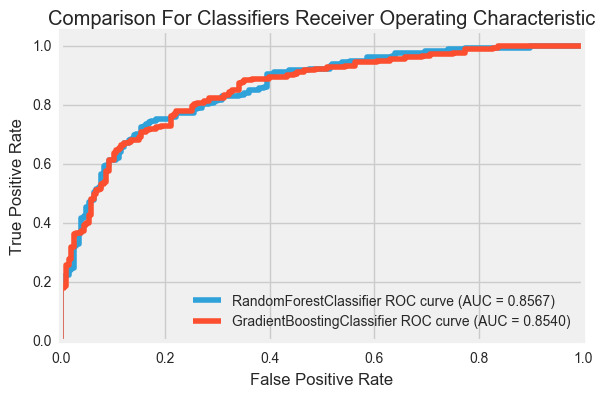

In [95]:
plot_roc_curve(best_model_rf, best_model_gbc)

In general, after tuning the hyper parameters of these two classifiers, the performance are very close. Different applicantions have different cost metric for the roc curve. Without the inforamtion about cost benefit matrix and given that the objective of the task is to maximize AUC, we choose to use RandomForest Classifier. Finally, we retrain the the model with the best tuned parameters on the whole training dataset we are given to leverage the initially 20% of data that we split as test data. 

The final prediction result on the test.csv is in a separate file called the prediction.csv file 